In [22]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.spatial import Delaunay
import folium as f

g_pickle = "./data/02_cambridge.gpickle"
g = nx.read_gpickle(g_pickle)

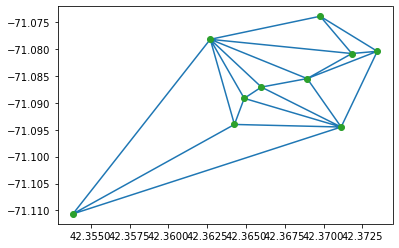

In [23]:
arbitrary_sub_g = random.sample(g.nodes().data(), 10) 

node_ids = [node[1]['id'] for node in arbitrary_sub_g]

points = []
for node in arbitrary_sub_g:
    lat, lon = node[1]['lat'], node[1]['lon']
    points.append([lat, lon])


points = np.array(points)
tri = Delaunay(points)


plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [24]:
def edges_from_simplex(tri):
    edges = [] 
    points = tri.points
    for simplex in tri.simplices:
        a = points[(simplex[0])].tolist()
        b = points[simplex[1]].tolist()
        c = points[simplex[2]].tolist()
        
        edges.append([a,b])
        edges.append([b,c])
        edges.append([c,a])
    
    return_edges = []
    for edge in edges:
        if edge not in return_edges and [edge[1], edge[0]] not in return_edges:
            return_edges.append(edge)
        
    
    return return_edges

edges = edges_from_simplex(tri)

edges

[[[42.3711329, -71.0945054], [42.3642595, -71.0940285]],
 [[42.3642595, -71.0940285], [42.3538542, -71.1106368]],
 [[42.3538542, -71.1106368], [42.3711329, -71.0945054]],
 [[42.3711329, -71.0945054], [42.364889, -71.0891839]],
 [[42.364889, -71.0891839], [42.3642595, -71.0940285]],
 [[42.3642595, -71.0940285], [42.362701, -71.0782277]],
 [[42.362701, -71.0782277], [42.3538542, -71.1106368]],
 [[42.364889, -71.0891839], [42.362701, -71.0782277]],
 [[42.3689446, -71.0855143], [42.3711329, -71.0945054]],
 [[42.3711329, -71.0945054], [42.3734607, -71.0804459]],
 [[42.3734607, -71.0804459], [42.3689446, -71.0855143]],
 [[42.3718201, -71.0808647], [42.3689446, -71.0855143]],
 [[42.3734607, -71.0804459], [42.3718201, -71.0808647]],
 [[42.3718201, -71.0808647], [42.362701, -71.0782277]],
 [[42.362701, -71.0782277], [42.3689446, -71.0855143]],
 [[42.3697828, -71.0739423], [42.3718201, -71.0808647]],
 [[42.3734607, -71.0804459], [42.3697828, -71.0739423]],
 [[42.3697828, -71.0739423], [42.362701

In [25]:
def node_id_from_latlon(latlon):
    lat,lon = latlon
    for node in g.nodes().data():
        if node[1]['lat'] == lat and node[1]['lon'] == lon:
            return (node[0])

In [26]:
walks = []

for edge1 in edges:
    for edge2 in edges:
        if edge1 == edge2: 
            continue
        elif edge1[0] == edge2[0]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[1],
                          "inter": [edge2[0]],
                          "dest": edge2[1]})
        elif edge1[0] == edge2[1]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[1],
                          "inter": [edge2[1]],
                          "dest": edge2[0]})
        elif edge1[1] == edge2[0]:
            walks.append({"walk": [edge1, edge2],
                           "source": edge1[0],
                           "inter": edge2[0],
                           "dest": edge2[1]})
        elif edge1[1] == edge2[1]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[0],
                          "inter": [edge2[1]],
                          "dest": edge2[0]})

In [27]:
def node_id_from_latlon(latlon):
    lat,lon = latlon
    for node in g.nodes().data():
        if node[1]['lat'] == lat and node[1]['lon'] == lon:
            return (node[0])
        
def dist_by_edge(edge): 
    a,b = edge
    lat_a,lon_a = a
    lat_b,lon_b = b
    a_id = node_id_from_latlon(a)
    b_id = node_id_from_latlon(b)
    try: 
        return nx.shortest_path_length(g, source=a_id, target=b_id, weight='havlen')
    except:
        return None


In [28]:
edges_to_eliminate = []

# The lower this number (between 0 and 1), the more lines eliminated
ELIMINATION_CUTOFF = .8

for walk in walks:
    BAD_DATA = False
    straight_distance = dist_by_edge((walk.get('source'), walk.get('dest')))
    if straight_distance is None: 
        BAD_DATA = True
        continue
    roundabout_distance = 0
    for edge in walk.get('walk'):  
        edge_dist = dist_by_edge(edge)
        if edge_dist is None: 
            BAD_DATA = True
            continue
        roundabout_distance += dist_by_edge(edge)
    if BAD_DATA: continue
    if (roundabout_distance * ELIMINATION_CUTOFF < straight_distance):
        edges_to_eliminate.append((node_id_from_latlon(walk.get('source')), node_id_from_latlon(walk.get('dest'))))

In [29]:
final_edges = []

for edge in edges:
    is_eliminated = False
    
    source, dest = edge
    source_id = node_id_from_latlon(source)
    dest_id = node_id_from_latlon(dest)
    for edge_to_elim in edges_to_eliminate:
        if (source_id, dest_id) == edge_to_elim:
            is_eliminated = True
            continue
    if not is_eliminated:
        final_edges.append(edge)
        
print ((str (len(edges) - len(final_edges))) + " lines removed out of " + str(len(edges)) + ". Too few? Too many? Change ELIMINATION_CUTOFF.")

5 lines removed out of 22. Too few? Too many? Change ELIMINATION_CUTOFF.


# Map of subgraph. If you don't like what you see, change ELIMINATION_CUTOFF

In [30]:
def shortest_path_by_edge(edge): 
    a,b = edge
    lat_a,lon_a = a
    lat_b,lon_b = b
    a_id = node_id_from_latlon(a)
    b_id = node_id_from_latlon(b)
    try: 
        return nx.shortest_path(g, source=a_id, target=b_id, weight='havlen')
    except:
        return None


m = f.Map(location = [42.3611108,-71.119977], zoom_start=14)

for node_data in g.nodes().data():
    node_id = node_data[1]["id"]
    lon,lat = node_data[1]['lon'], node_data[1]['lat'] 
    if node_id in node_ids:
        m.add_child(f.Marker(location=[lat,lon], color="blue", radius=1, tooltip=node_id))

        
for final_edge in final_edges:
    short_path_edges = shortest_path_by_edge(final_edge)
    if short_path_edges is None: continue
    
    line_locations = [[g.nodes()[n_id]['lat'], g.nodes()[n_id]['lon']] for n_id in short_path_edges]
    m.add_child(f.PolyLine(locations=line_locations, line_opacity=1, color="magenta"))

m